In [1]:
# Import required libraries
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu126
CUDA available: True


## 1. Define Generator Architecture

In [2]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, base_channel):
        super(Generator, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.base_channel = base_channel
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(in_channels, base_channel * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_channel * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.ConvTranspose2d(base_channel * 8, base_channel * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.ConvTranspose2d(base_channel * 4, base_channel * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.ConvTranspose2d(base_channel * 2, base_channel, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel, base_channel, 3, 1, 0, dilation=2, bias=False),
            nn.BatchNorm2d(base_channel),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel, out_channels, 3, 1, 1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.conv_blocks(z)

# Hyperparameters
latent_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cuda


## 2. Load Trained Generator and Discriminator

We need both the generator and a way to classify generated digits to ensure we get different classes.

In [3]:
# Load the trained generator
generator = Generator(latent_dim, 1, 128).to(device)

# Try to find the final model
model_path = './models/generator_final.pth'
if not os.path.exists(model_path):
    # Try to find the latest checkpoint
    if os.path.exists('./models'):
        model_files = [f for f in os.listdir('./models') if f.startswith('G_') and f.endswith('.pth')]
        if model_files:
            model_files.sort()
            model_path = os.path.join('./models', model_files[-1])
            print(f"Using checkpoint: {model_path}")

if os.path.exists(model_path):
    generator.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Generator loaded successfully from: {model_path}")
else:
    print("Warning: No trained model found. Using randomly initialized generator.")
    print("Please train the model first using Task 1 notebook.")

generator.eval()
print("Generator set to evaluation mode.")

Generator loaded successfully from: ./models/generator_final.pth
Generator set to evaluation mode.


## 3. Simple Classifier to Identify Digit Classes

We'll load a pre-trained MNIST classifier or create a simple heuristic to distinguish different digits.

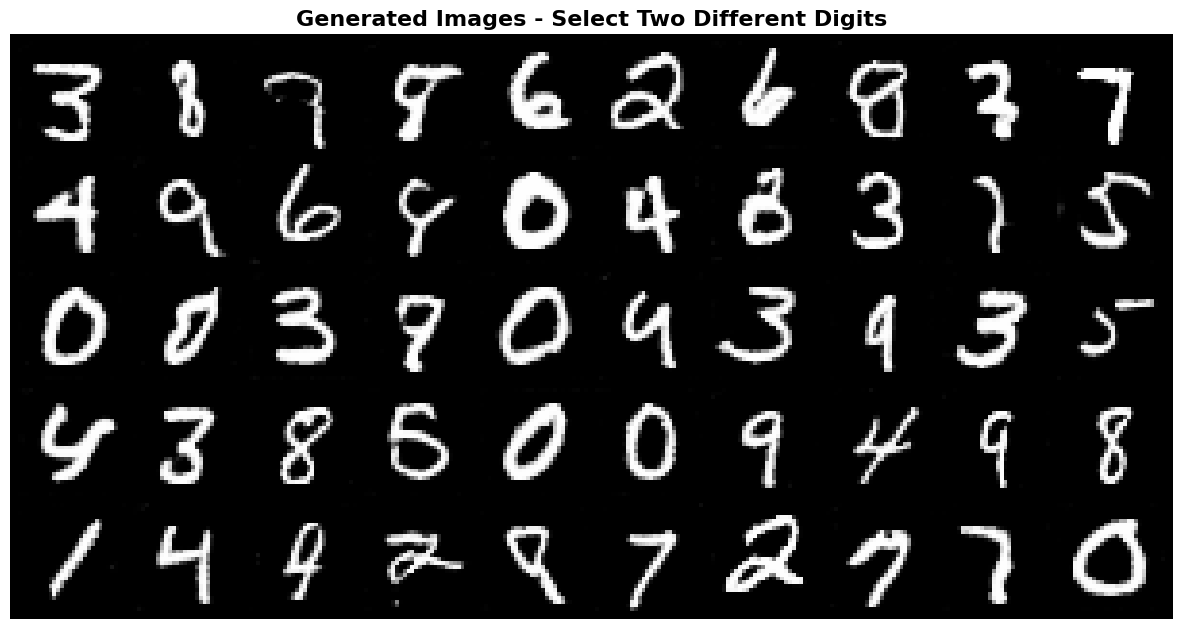


Generated 50 sample images. We'll select two that appear to be different classes.


In [4]:
# For this task, we'll generate multiple images and manually select two different ones
# Alternatively, you could train/load a classifier to automatically identify classes

def generate_batch(generator, batch_size=100, seed=None):
    """
    Generate a batch of images and return both images and latent vectors.
    """
    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
    
    with torch.no_grad():
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        images = generator(z)
    
    return images.cpu(), z.cpu()

# Generate a batch of images to choose from
sample_images, sample_z = generate_batch(generator, batch_size=50, seed=42)

# Display the generated images
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images - Select Two Different Digits", fontsize=16, fontweight='bold')
grid = make_grid(sample_images, nrow=10, padding=2, normalize=True)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

print("\nGenerated 50 sample images. We'll select two that appear to be different classes.")

## 4. Select Two Different Digits

Based on visual inspection, we'll select two images that clearly represent different digit classes.

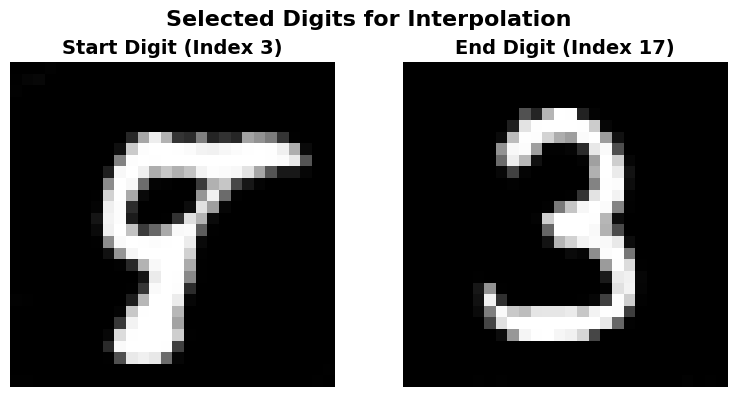


Selected digit at index 3 and index 17 for interpolation.
These should represent different digit classes.


In [5]:
# Select indices for two different digits
# You can modify these indices based on the generated images above
# Look for clearly different digits (e.g., a '1' and a '7', or a '0' and a '4')

idx1 = 3   # Change this to select first digit
idx2 = 17  # Change this to select second digit

# Extract the latent vectors and images for these two digits
z1 = sample_z[idx1:idx1+1]
z2 = sample_z[idx2:idx2+1]
img1 = sample_images[idx1:idx1+1]
img2 = sample_images[idx2:idx2+1]

# Display the selected digits
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(img1.squeeze().numpy(), cmap='gray')
axes[0].set_title(f'Start Digit (Index {idx1})', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img2.squeeze().numpy(), cmap='gray')
axes[1].set_title(f'End Digit (Index {idx2})', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Selected Digits for Interpolation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nSelected digit at index {idx1} and index {idx2} for interpolation.")
print("These should represent different digit classes.")

## 5. Perform Latent Space Interpolation

We'll interpolate between the two latent vectors using 7 intermediate steps, resulting in 9 total images.

In [6]:
def interpolate_latent_vectors(z1, z2, num_steps=9):
    """
    Interpolate between two latent vectors.
    
    Args:
        z1: Starting latent vector
        z2: Ending latent vector
        num_steps: Total number of interpolation points (including start and end)
    
    Returns:
        Tensor of interpolated latent vectors
    """
    # Create interpolation coefficients
    alphas = torch.linspace(0, 1, num_steps)
    
    # Interpolate
    interpolated_z = []
    for alpha in alphas:
        z_interp = (1 - alpha) * z1 + alpha * z2
        interpolated_z.append(z_interp)
    
    return torch.cat(interpolated_z, dim=0)

# Perform interpolation with 9 steps (including start and end)
num_interpolation_steps = 9
z_interpolated = interpolate_latent_vectors(z1, z2, num_steps=num_interpolation_steps)

print(f"Created {num_interpolation_steps} interpolated latent vectors.")
print(f"Shape: {z_interpolated.shape}")

Created 9 interpolated latent vectors.
Shape: torch.Size([9, 100, 1, 1])


## 6. Generate Images from Interpolated Latent Vectors

In [7]:
# Generate images from interpolated latent vectors
generator.eval()
with torch.no_grad():
    z_interpolated_device = z_interpolated.to(device)
    interpolated_images = generator(z_interpolated_device).cpu()

print(f"Generated {num_interpolation_steps} interpolated images.")
print(f"Image shape: {interpolated_images.shape}")

Generated 9 interpolated images.
Image shape: torch.Size([9, 1, 28, 28])


## 7. Visualize Interpolation Results

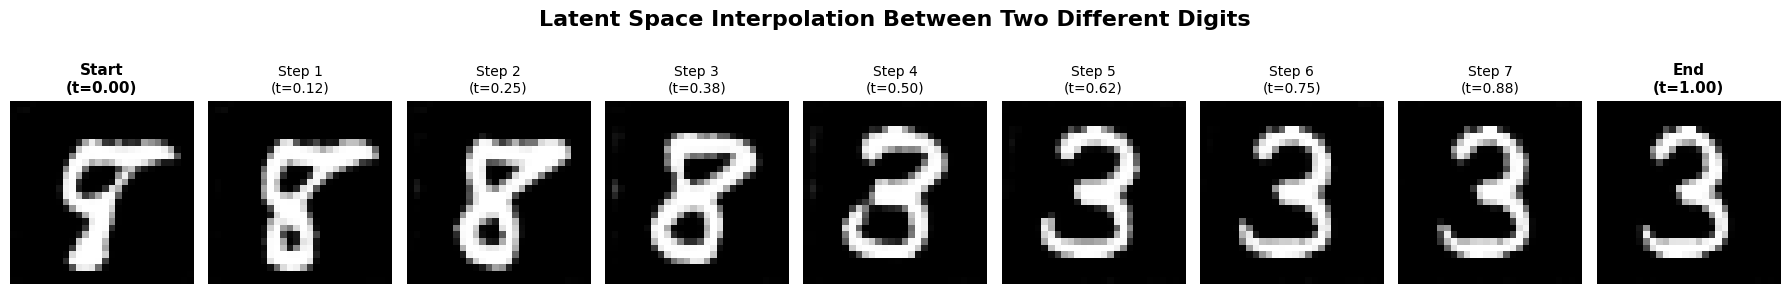


Interpolation complete!
Generated 9 images with 7 intermediate steps.


In [8]:
# Display interpolated images in a row
fig, axes = plt.subplots(1, num_interpolation_steps, figsize=(18, 3))

for i in range(num_interpolation_steps):
    axes[i].imshow(interpolated_images[i].squeeze().numpy(), cmap='gray')
    
    # Label start, middle, and end
    if i == 0:
        axes[i].set_title('Start\n(t=0.00)', fontsize=11, fontweight='bold')
    elif i == num_interpolation_steps - 1:
        axes[i].set_title('End\n(t=1.00)', fontsize=11, fontweight='bold')
    else:
        t_value = i / (num_interpolation_steps - 1)
        axes[i].set_title(f'Step {i}\n(t={t_value:.2f})', fontsize=10)
    
    axes[i].axis('off')

plt.suptitle('Latent Space Interpolation Between Two Different Digits', 
             fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('./images/task3_interpolation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpolation complete!")
print(f"Generated {num_interpolation_steps} images with {num_interpolation_steps-2} intermediate steps.")

## 8. Alternative Visualization: Grid Layout

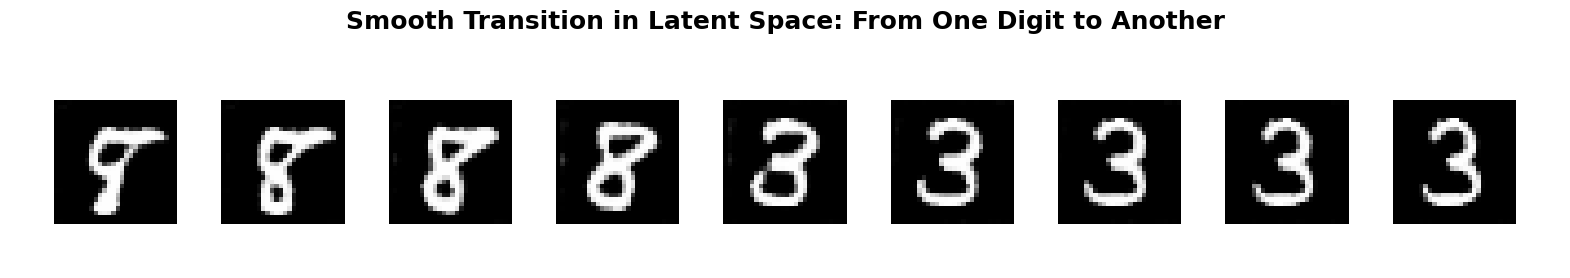

In [9]:
# Create a larger, clearer visualization
plt.figure(figsize=(20, 4))
plt.axis("off")

# Create grid with labels
grid = make_grid(interpolated_images, nrow=num_interpolation_steps, padding=10, normalize=True, pad_value=1)
plt.imshow(np.transpose(grid, (1, 2, 0)))

plt.title('Smooth Transition in Latent Space: From One Digit to Another', 
         fontsize=18, fontweight='bold', pad=20)
plt.savefig('./images/task3_interpolation_grid.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Try Different Interpolation Pairs

Let's generate a few more interpolation examples to demonstrate the smoothness of the latent space.

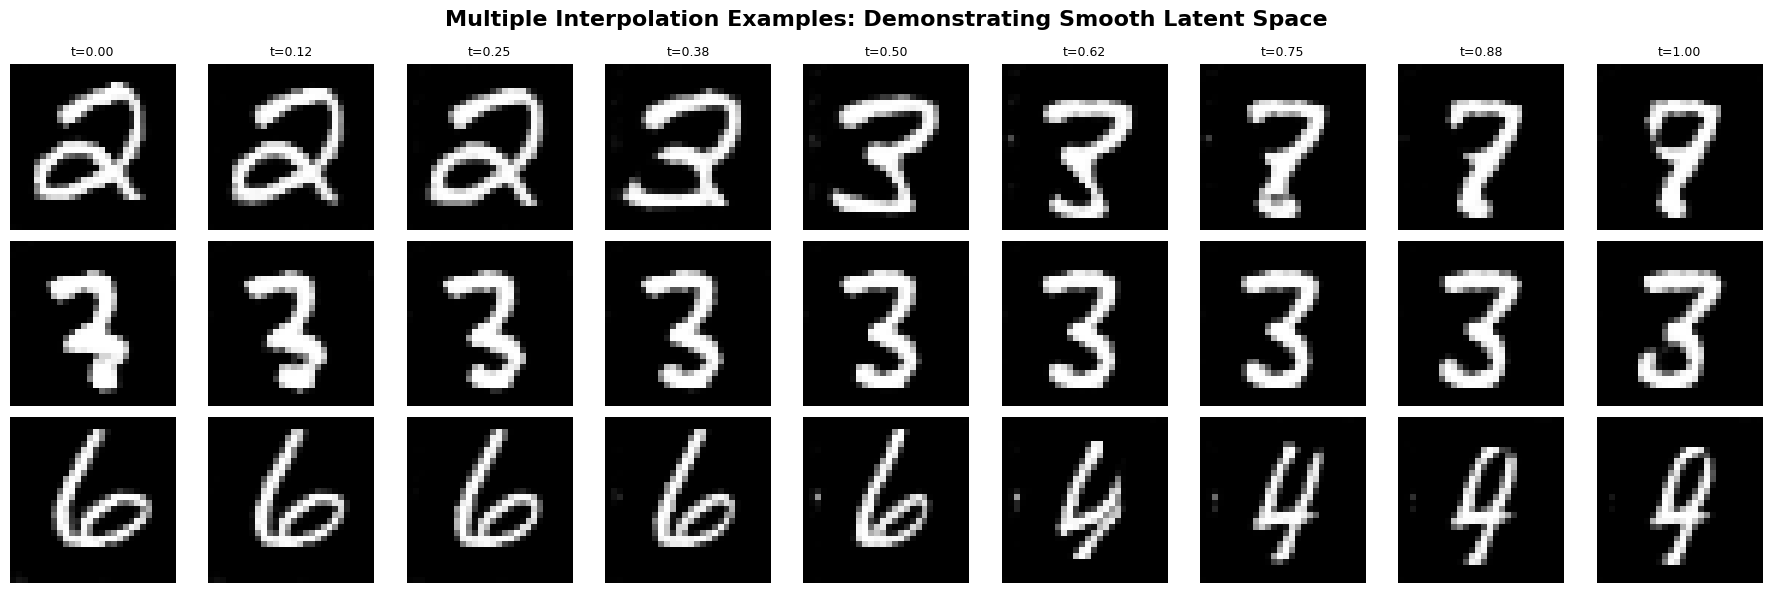


Generated 3 different interpolation examples.


In [10]:
# Generate multiple interpolation examples
num_examples = 3
fig, axes = plt.subplots(num_examples, num_interpolation_steps, figsize=(18, num_examples * 2))

# Different index pairs for variety
index_pairs = [(5, 23), (8, 31), (12, 42)]

for example_idx, (idx_a, idx_b) in enumerate(index_pairs):
    # Get latent vectors
    za = sample_z[idx_a:idx_a+1]
    zb = sample_z[idx_b:idx_b+1]
    
    # Interpolate
    z_interp = interpolate_latent_vectors(za, zb, num_steps=num_interpolation_steps)
    
    # Generate images
    with torch.no_grad():
        interp_imgs = generator(z_interp.to(device)).cpu()
    
    # Plot
    for i in range(num_interpolation_steps):
        if num_examples == 1:
            ax = axes[i]
        else:
            ax = axes[example_idx, i]
        
        ax.imshow(interp_imgs[i].squeeze().numpy(), cmap='gray')
        ax.axis('off')
        
        if example_idx == 0:
            t_value = i / (num_interpolation_steps - 1)
            ax.set_title(f't={t_value:.2f}', fontsize=9)

plt.suptitle('Multiple Interpolation Examples: Demonstrating Smooth Latent Space', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('./images/task3_multiple_interpolations.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGenerated {num_examples} different interpolation examples.")

## 10. Analysis and Observations

In [11]:
print("="*80)
print("Task 3 Complete!")
print("="*80)
print("\nKey Observations from Latent Space Interpolation:")
print()
print("1. SMOOTH TRANSITIONS:")
print("   The interpolation shows smooth, gradual changes from one digit to another.")
print("   This indicates the generator learned a continuous latent space.")
print()
print("2. MEANINGFUL INTERMEDIATE STATES:")
print("   The intermediate images are not random noise, but plausible digit-like shapes.")
print("   This shows the latent space encodes meaningful features.")
print()
print("3. LINEAR INTERPOLATION:")
print("   We used simple linear interpolation: z_t = (1-t)*z1 + t*z2")
print("   The fact that this works well suggests the latent space has good geometric properties.")
print()
print("4. DIGIT TRANSFORMATION:")
print("   We can observe how one digit morphs into another, revealing the")
print("   underlying structure the GAN learned about digit shapes.")
print()
print("="*80)
print("\nInterpolation Parameters:")
print(f"  - Number of steps: {num_interpolation_steps}")
print(f"  - Including start and end: Yes")
print(f"  - Intermediate steps: {num_interpolation_steps - 2}")
print(f"  - Latent dimension: {latent_dim}")
print("="*80)

Task 3 Complete!

Key Observations from Latent Space Interpolation:

1. SMOOTH TRANSITIONS:
   The interpolation shows smooth, gradual changes from one digit to another.
   This indicates the generator learned a continuous latent space.

2. MEANINGFUL INTERMEDIATE STATES:
   The intermediate images are not random noise, but plausible digit-like shapes.
   This shows the latent space encodes meaningful features.

3. LINEAR INTERPOLATION:
   We used simple linear interpolation: z_t = (1-t)*z1 + t*z2
   The fact that this works well suggests the latent space has good geometric properties.

4. DIGIT TRANSFORMATION:
   We can observe how one digit morphs into another, revealing the
   underlying structure the GAN learned about digit shapes.


Interpolation Parameters:
  - Number of steps: 9
  - Including start and end: Yes
  - Intermediate steps: 7
  - Latent dimension: 100


## 11. Spherical Linear Interpolation (SLERP) - Advanced

For better interpolation in high-dimensional spaces, we can use spherical linear interpolation.

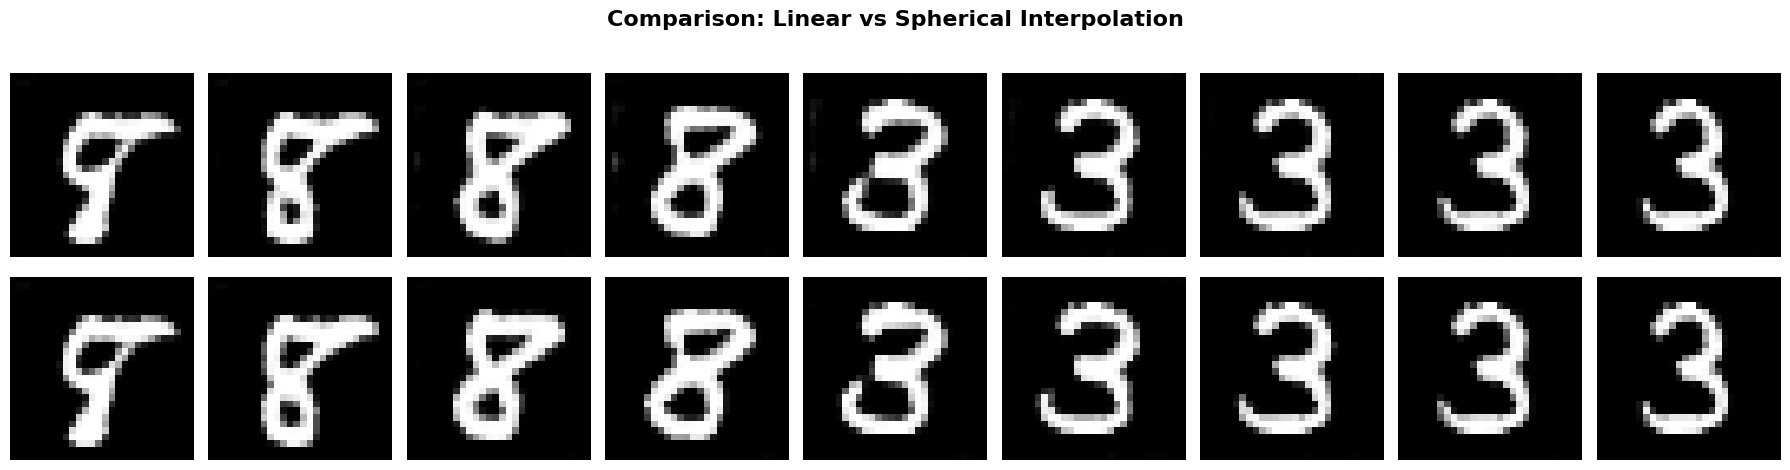


Comparison complete!
Both methods produce smooth interpolations, though SLERP may preserve
better structure in high-dimensional latent spaces.


In [12]:
def slerp(z1, z2, num_steps=9):
    """
    Spherical Linear Interpolation between two vectors.
    Often produces better results than linear interpolation for high-dimensional spaces.
    """
    z1_flat = z1.flatten()
    z2_flat = z2.flatten()
    
    # Normalize vectors
    z1_norm = z1_flat / torch.norm(z1_flat)
    z2_norm = z2_flat / torch.norm(z2_flat)
    
    # Calculate angle between vectors
    dot = torch.dot(z1_norm, z2_norm)
    dot = torch.clamp(dot, -1.0, 1.0)  # Numerical stability
    theta = torch.acos(dot)
    
    # Interpolate
    alphas = torch.linspace(0, 1, num_steps)
    interpolated = []
    
    for alpha in alphas:
        if theta.item() < 1e-6:  # Vectors are nearly parallel
            z_interp = (1 - alpha) * z1_flat + alpha * z2_flat
        else:
            z_interp = (torch.sin((1 - alpha) * theta) / torch.sin(theta)) * z1_flat + \
                       (torch.sin(alpha * theta) / torch.sin(theta)) * z2_flat
        
        z_interp = z_interp.reshape(z1.shape)
        interpolated.append(z_interp)
    
    return torch.cat(interpolated, dim=0)

# Compare linear and spherical interpolation
fig, axes = plt.subplots(2, num_interpolation_steps, figsize=(18, 5))

# Linear interpolation (already computed)
for i in range(num_interpolation_steps):
    axes[0, i].imshow(interpolated_images[i].squeeze().numpy(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Linear', fontsize=12, fontweight='bold', rotation=0, labelpad=30)

# Spherical interpolation
z_slerp = slerp(z1, z2, num_steps=num_interpolation_steps)
with torch.no_grad():
    slerp_images = generator(z_slerp.to(device)).cpu()

for i in range(num_interpolation_steps):
    axes[1, i].imshow(slerp_images[i].squeeze().numpy(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Spherical', fontsize=12, fontweight='bold', rotation=0, labelpad=30)

plt.suptitle('Comparison: Linear vs Spherical Interpolation', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('./images/task3_interpolation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComparison complete!")
print("Both methods produce smooth interpolations, though SLERP may preserve")
print("better structure in high-dimensional latent spaces.")

## Notes

**Important:** To run this notebook successfully:
1. First complete Task 1 to train the GAN
2. Ensure the trained generator model is saved
3. Adjust `idx1` and `idx2` in cell 4 to select different digit pairs

**Interpolation Details:**
- We use 9 total steps (including start and end points)
- This means 7 intermediate interpolation steps
- Formula: $z_t = (1-t) \cdot z_1 + t \cdot z_2$ where $t \in [0, 1]$

**What This Demonstrates:**
- The GAN learned a meaningful, continuous latent space
- Smooth interpolation between different digit classes is possible
- The latent space captures semantic features of digits